## Exploring the Dataset

In [1]:
import pandas as pd #For reading dataset files
import networkx as nx #For network creation/analysis
from networkx.algorithms import community
import matplotlib.pyplot as plt #For plotting graphs
%matplotlib inline

In [2]:
G = nx.karate_club_graph()

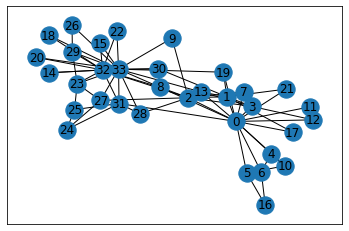

In [3]:
nx.draw_networkx(G)

## Implementing Label Propogation using the algorithm in the following paper:
https://arxiv.org/pdf/1103.4550.pdf

In [34]:
from statistics import mode
from collections import defaultdict
def labelPropagation(G, labels, iters = 100):
    ## assign color to all nodes 
    colors = greedyColoring(nx.adjacency_data(G)['adjacency'], len(G.nodes))
    colorDict = defaultdict(list)
    
    for i in range(len(colors)):
        colorDict[colors[i]].append(i)
        
    curr_labels = labels.copy()
    prev_labels = labels.copy()
    
    ## begin propagation
    for i in range(iters):
        for j in range(max(colors)+1):
            for v in colorDict[j]:
                count  = []
                for u in nx.adjacency_data(G)['adjacency'][v]:
                    u = u['id']
                    if colors[u] < colors[v] and curr_labels[u] != -1:
                        count.append(curr_labels[u])
                    elif colors[u] > colors[v] and prev_labels[u] != -1:
                        count.append(prev_labels[u])
                if len(count) > 0:
                    curr_labels[v] = mode(count)

        prev_labels = curr_labels.copy()
    
    return curr_labels
                

In [5]:
def greedyColoring(adj, V):
     
    result = [-1] * V
 
    # Assign the first color to first vertex
    result[0] = 0;
 
 
    # A temporary array to store the available colors.
    # True value of available[cr] would mean that the
    # color cr is assigned to one of its adjacent vertices
    available = [False] * V
 
    # Assign colors to remaining V-1 vertices
    for u in range(1, V):
         
        # Process all adjacent vertices and
        # flag their colors as unavailable
        for i in adj[u]:
            if (result[i['id']] != -1):
                available[result[i['id']]] = True
 
        # Find the first available color
        cr = 0
        while cr < V:
            if (available[cr] == False):
                break
             
            cr += 1
             
        # Assign the found color
        result[u] = cr
 
        # Reset the values back to false
        # for the next iteration
        for i in adj[u]:
            if (result[i['id']] != -1):
                available[result[i['id']]] = False
                
        
    return result

In [6]:
def createTrueLabels(G):
    labels = []
    for i in range(len(G.nodes)):
        if G.nodes[i]['club'] == 'Mr. Hi':
            labels.append(1)
        else:
            labels.append(0)
    return labels

## Implementing a smarter Selection Algorithm

We use the topological information of the grpah to perform spectral clustering. We create two clusters as these are the number of unique classes in our database. Then from each cluster we pick K/2 (where K is the number of inital nodes selected) nodes with the highest degree. This should allow us to perform quite well and hopefully beat random selection in many cases. This algorithm is implemented in the "selectSmarterInitalNodes(G, labels, k)" function in the cell below.

In [12]:
import random
from sklearn.cluster import SpectralClustering
import numpy as np

def selectInitialNodes(labels, k):
    labelSubset = [-1]*len(labels)
    idx = random.sample(list(range(len(labels))), k)
    for node in idx:
        labelSubset[node] = labels[node]
  
    return labelSubset

def selectSmarterInitalNodes(G, labels, k):
    adjacencyList = nx.adjacency_matrix(G).todense()
    adjacencyList = np.array(adjacencyList)
    clusterLabels = SpectralClustering(n_clusters=2, assign_labels = 'kmeans', random_state = 0,\
                                    affinity='precomputed').fit(adjacencyList)
    sortedLabels = sorted(G.nodes, key = lambda x: (clusterLabels.labels_, G.degree[x]), reverse=True)
    labelSubset = [-1]*len(labels)
    
    class_count = [0, 0]

    
    for node in sortedLabels:
        if class_count[clusterLabels.labels_[node]] >= k/2:
            continue
        else:
            labelSubset[node] = labels[node]
            class_count[clusterLabels.labels_[node]] += 1
        
    return labelSubset

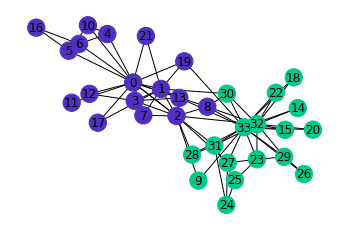

In [8]:
## colormap of true labels
Gtruth = createTrueLabels(G)

colors = ["#00C98D", "#5030C0"]
pos = nx.spring_layout(G)
color_map_b = {}

for i,c in enumerate(Gtruth):
    color_map_b[i] = colors[c]

nx.draw_networkx_edges(G, pos)
nx.draw_networkx_nodes(G, pos, node_color=dict(color_map_b).values())
nx.draw_networkx_labels(G, pos)
plt.axis("off")
plt.show()

## Comparison of K=2

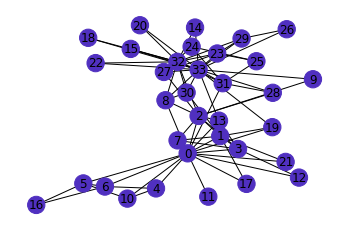

accuracy= 0.5, f1score= 0.6666666666666666, precision=0.5, recall=1.0


In [13]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

## color map with randomly selected inital nodes
initalLabels = selectInitialNodes(Gtruth, 2)
propagationOut = labelPropagation(G, initalLabels)


colors = ["#00C98D", "#5030C0"]
pos = nx.spring_layout(G)
color_map_b = {}

for i,c in enumerate(propagationOut):
    color_map_b[i] = colors[c]

nx.draw_networkx_edges(G, pos)
nx.draw_networkx_nodes(G, pos, node_color=dict(color_map_b).values())
nx.draw_networkx_labels(G, pos)
plt.axis("off")
plt.show()

## metrics for comparison
f1score=f1_score(Gtruth,propagationOut)
accscore=accuracy_score(Gtruth,propagationOut)
precisionscore=precision_score(Gtruth,propagationOut)
recallscore=recall_score(Gtruth,propagationOut)
print(f'accuracy= {accscore}, f1score= {f1score}, precision={precisionscore}, recall={recallscore}')

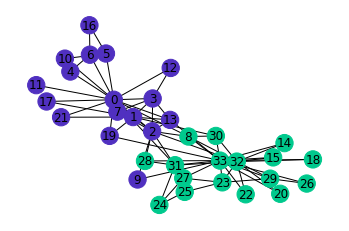

accuracy= 0.9411764705882353, f1score= 0.9411764705882353, precision=0.9411764705882353, recall=0.9411764705882353


In [35]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

## color map with 4 randomly selected inital nodes
initalLabels = selectSmarterInitalNodes(G, Gtruth, 2)
propagationOut = labelPropagation(G, initalLabels)

colors = ["#00C98D", "#5030C0"]
pos = nx.spring_layout(G)
color_map_b = {}

for i,c in enumerate(propagationOut):
    color_map_b[i] = colors[c]

nx.draw_networkx_edges(G, pos)
nx.draw_networkx_nodes(G, pos, node_color=dict(color_map_b).values())
nx.draw_networkx_labels(G, pos)
plt.axis("off")
plt.show()

## metrics for comparison
f1score=f1_score(Gtruth,propagationOut)
accscore=accuracy_score(Gtruth,propagationOut)
precisionscore=precision_score(Gtruth,propagationOut)
recallscore=recall_score(Gtruth,propagationOut)
print(f'accuracy= {accscore}, f1score= {f1score}, precision={precisionscore}, recall={recallscore}')

## Comparison of K=4

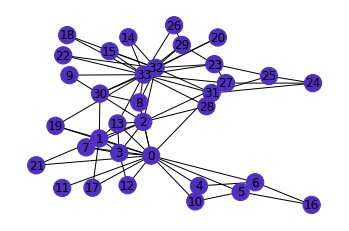

accuracy= 0.5, f1score= 0.6666666666666666, precision=0.5, recall=1.0


In [31]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

## color map with randomly selected inital nodes
initalLabels = selectInitialNodes(Gtruth, 4)
propagationOut = labelPropagation(G, initalLabels)


colors = ["#00C98D", "#5030C0"]
pos = nx.spring_layout(G)
color_map_b = {}

for i,c in enumerate(propagationOut):
    color_map_b[i] = colors[c]

nx.draw_networkx_edges(G, pos)
nx.draw_networkx_nodes(G, pos, node_color=dict(color_map_b).values())
nx.draw_networkx_labels(G, pos)
plt.axis("off")
plt.show()

## metrics for comparison
f1score=f1_score(Gtruth,propagationOut)
accscore=accuracy_score(Gtruth,propagationOut)
precisionscore=precision_score(Gtruth,propagationOut)
recallscore=recall_score(Gtruth,propagationOut)
print(f'accuracy= {accscore}, f1score= {f1score}, precision={precisionscore}, recall={recallscore}')

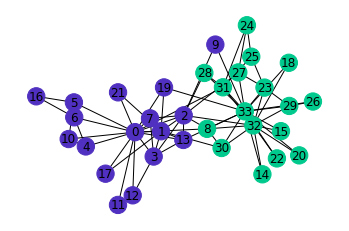

accuracy= 0.9411764705882353, f1score= 0.9411764705882353, precision=0.9411764705882353, recall=0.9411764705882353


In [36]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

## color map with 4 randomly selected inital nodes
initalLabels = selectSmarterInitalNodes(G, Gtruth, 4)
propagationOut = labelPropagation(G, initalLabels)

colors = ["#00C98D", "#5030C0"]
pos = nx.spring_layout(G)
color_map_b = {}

for i,c in enumerate(propagationOut):
    color_map_b[i] = colors[c]

nx.draw_networkx_edges(G, pos)
nx.draw_networkx_nodes(G, pos, node_color=dict(color_map_b).values())
nx.draw_networkx_labels(G, pos)
plt.axis("off")
plt.show()

## metrics for comparison
f1score=f1_score(Gtruth,propagationOut)
accscore=accuracy_score(Gtruth,propagationOut)
precisionscore=precision_score(Gtruth,propagationOut)
recallscore=recall_score(Gtruth,propagationOut)
print(f'accuracy= {accscore}, f1score= {f1score}, precision={precisionscore}, recall={recallscore}')

## Comparsion of K=6

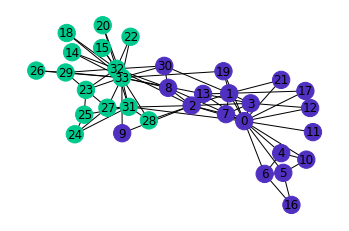

accuracy= 0.9411764705882353, f1score= 0.9444444444444444, precision=0.8947368421052632, recall=1.0


In [32]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

## color map with randomly selected inital nodes
initalLabels = selectInitialNodes(Gtruth, 6)
propagationOut = labelPropagation(G, initalLabels)


colors = ["#00C98D", "#5030C0"]
pos = nx.spring_layout(G)
color_map_b = {}

for i,c in enumerate(propagationOut):
    color_map_b[i] = colors[c]

nx.draw_networkx_edges(G, pos)
nx.draw_networkx_nodes(G, pos, node_color=dict(color_map_b).values())
nx.draw_networkx_labels(G, pos)
plt.axis("off")
plt.show()

## metrics for comparison
f1score=f1_score(Gtruth,propagationOut)
accscore=accuracy_score(Gtruth,propagationOut)
precisionscore=precision_score(Gtruth,propagationOut)
recallscore=recall_score(Gtruth,propagationOut)
print(f'accuracy= {accscore}, f1score= {f1score}, precision={precisionscore}, recall={recallscore}')

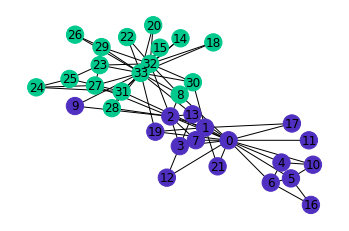

accuracy= 0.9411764705882353, f1score= 0.9411764705882353, precision=0.9411764705882353, recall=0.9411764705882353


In [37]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

## color map with 4 randomly selected inital nodes
initalLabels = selectSmarterInitalNodes(G, Gtruth, 6)
propagationOut = labelPropagation(G, initalLabels)

colors = ["#00C98D", "#5030C0"]
pos = nx.spring_layout(G)
color_map_b = {}

for i,c in enumerate(propagationOut):
    color_map_b[i] = colors[c]

nx.draw_networkx_edges(G, pos)
nx.draw_networkx_nodes(G, pos, node_color=dict(color_map_b).values())
nx.draw_networkx_labels(G, pos)
plt.axis("off")
plt.show()

## metrics for comparison
f1score=f1_score(Gtruth,propagationOut)
accscore=accuracy_score(Gtruth,propagationOut)
precisionscore=precision_score(Gtruth,propagationOut)
recallscore=recall_score(Gtruth,propagationOut)
print(f'accuracy= {accscore}, f1score= {f1score}, precision={precisionscore}, recall={recallscore}')

## Discussing results

As we can see, in cased K=2 and K=4, there is a possibility that random selection picks nodes from only a single class leading to exteremely poor performance. However as K increases, it becomes increasingly unlikely for random selection to pick nodes of only a singular class and from K=6 onwards we see similar performance. 